In [41]:
#import all the libraries we need
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import helpers as dsfh
import missingno as msno
from pyaxis import pyaxis
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn import linear_model
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import predhelp as ph
from sklearn.preprocessing import PolynomialFeatures
fp = r"../data/px-x-1003020000_101.px" 

In [29]:
#define the region we want to analyse and three competitors
saanen = ph.get_region(fp,"Saanen","St. Moritz","Arosa","Zermatt")
#define our gdp data
gdp = ph.gdp_clean("../data/gdpPC.csv")


In [30]:

#import the weather data from three different stations
weather_chd = ph.weather_clean("../data/WeatherBetter/chd.csv")
weather_gsg = ph.weather_clean("../data/WeatherBetter/gsg.csv")
weather_zwe = ph.weather_clean("../data/WeatherBetter/zwe.csv")


In [59]:
def forex_clean (csv_data_url):
    exchange_rate = pd.read_csv(f"{csv_data_url}", sep = ";", skiprows = 2)
    exchange_rate[["y","m"]] = exchange_rate["Date"].str.split("-",expand=True)
    exchange_rate["y"] = exchange_rate["y"].astype(int)
    del exchange_rate["Date"]
    del exchange_rate["D0"]
    exchange_rate = exchange_rate.loc[exchange_rate["y"]>=2013].reset_index()
    exchange_rate_wide = exchange_rate.pivot(index=["y", "m"], columns="D1", values="Value").reset_index().rename_axis(None, axis=1)
    colnamesexrate = exchange_rate_wide.columns.tolist()
    exchange_rate_wide = exchange_rate_wide.add_suffix('_exrate')
    exchange_rate_wide.rename(columns = {'y_exrate':'Year', 'm_exrate':'Month'}, inplace = True)
    del exchange_rate_wide["Year"]
    del exchange_rate_wide["Month"]
    if 117 in exchange_rate_wide.index:
        exchange_rate_wide.drop(index=[117], inplace=True)
        return(exchange_rate_wide)
    return(exchange_rate_wide)

def ppi_clean(ppi_data_csv_url):
    PPI = pd.read_csv(f'{ppi_data_csv_url}')
    PPI[["y","m"]] = PPI["TIME"].str.split("-",expand=True)
    PPI["y"] = PPI["y"].astype(int)
    PPI.drop(labels = ['INDICATOR','SUBJECT','MEASURE','FREQUENCY','Flag Codes'], axis = 1, inplace = True)
    del PPI["TIME"]
    PPI = PPI.loc[PPI["y"]>=2013].reset_index()
    PPI_wide = PPI.pivot(index=["y", "m"], columns="LOCATION", values="Value").reset_index().rename_axis(None, axis=1)
    colnamesunemprate = PPI_wide.columns.tolist()
    PPI_wide = PPI_wide.add_suffix('_unemprate')
    PPI_wide.rename(columns = {'y_unemprate':'y', 'm_unemprate':'m'}, inplace = True)
    if 117 in PPI_wide.index:
        PPI_wide.drop(index=[117], inplace=True)
        return(PPI_wide)
   # PI_wide["DATE"] = datelist 
    PPI_wide.drop(labels = ['y','m'], axis = 1, inplace = True)
    for i in PPI_wide.columns[PPI_wide.isnull().any(axis=0)]:     #---Applying Only on variables with NaN values
        PPI_wide[i].fillna(PPI_wide[i].mean(),inplace=True)
    return(PPI_wide)

def unemployment_clean (csv_data_url):
    unemployment_rate = pd.read_csv(f'{csv_data_url}')
    unemployment_rate[["y","m"]] = unemployment_rate["TIME"].str.split("-",expand=True)
    unemployment_rate["y"] = unemployment_rate["y"].astype(int)
    unemployment_rate = unemployment_rate.loc[unemployment_rate["y"]>=2013].reset_index()
    unemployment_rate.drop(labels = ['INDICATOR','SUBJECT','MEASURE','FREQUENCY','Flag Codes'], axis = 1, inplace = True)
    unemployment_rate.rename(columns={"LOCATION":"iso"}, inplace = True)
    unemployment_rate_wide = unemployment_rate.pivot(index=['y', 'm'], columns="iso", values="Value").reset_index().rename_axis(None, axis=1)
    unemployment_rate_wide.drop(columns=["y","m"], axis=1, inplace=True)
    unemployment_rate_wide = unemployment_rate_wide.add_suffix('_unemprate')
    if 117 in unemployment_rate_wide.index:
        unemployment_rate_wide.drop(index=[117], inplace=True)
        return(unemployment_rate_wide)
    unemployment_rate_wide['DATE'] = datelist
    for i in unemployment_rate_wide.columns[unemployment_rate_wide.isnull().any(axis=0)]:     #---Applying Only on variables with NaN values
        unemployment_rate_wide[i].fillna(unemployment_rate_wide[i].mean(),inplace=True)

    return(unemployment_rate_wide)


In [43]:
xr = pd.read_csv("../data/SNB_Xrate_20y.csv", sep= ";", skiprows = 2)
xr

,Date,D0,D1,Value
0,1914-10,M0,EUR1,NaN
1,1914-10,M0,GBP1,25.29200
2,1914-10,M0,DKK100,NaN
3,1914-10,M0,NOK100,NaN
4,1914-10,M0,CZK100,NaN
...,...,...,...,...
32420,2022-10,M0,KRW100,0.06979
32421,2022-10,M0,MYR100,21.20690
32422,2022-10,M0,NZD1,0.56614
32423,2022-10,M0,SGD1,0.69870


In [60]:
xrate = forex_clean("../data/SNB_Xrate_20y.csv")
#ppi = ppi_clean("../data/Producer_price_indices.csv")
unemployment = unemployment_clean("../data/Unemployment_rate.csv")
xrate

,ARS1_exrate,AUD1_exrate,BRL100_exrate,CAD1_exrate,CNY100_exrate,CZK100_exrate,DKK100_exrate,EUR1_exrate,GBP1_exrate,HKD100_exrate,...,NOK100_exrate,NZD1_exrate,PLN100_exrate,RUB1_exrate,SEK100_exrate,SGD1_exrate,THB100_exrate,TRY100_exrate,USD1_exrate,ZAR1_exrate
0,18.67700,0.97002,45.46090,0.93180,14.70635,4.81060,16.45610,1.22800,1.47680,11.91839,...,16.64220,0.77340,29.67480,0.03060,14.23780,0.75240,3.07180,52.14739,0.92410,0.10530
1,18.37300,0.94904,46.56500,0.91240,14.66380,4.82820,16.48350,1.22980,1.42480,11.86465,...,16.55750,0.77190,29.47550,0.03050,14.45250,0.74300,3.08490,51.78650,0.92020,0.10340
2,18.60100,0.97811,47.63330,0.92320,15.08571,4.78020,16.44900,1.22640,1.42700,12.19293,...,16.38140,0.78340,29.51190,0.03070,14.69380,0.75900,3.20530,52.27762,0.94600,0.10290
3,18.20450,0.97392,46.77730,0.92040,14.99827,4.71990,16.36140,1.21980,1.43470,12.07996,...,16.17360,0.79470,29.46180,0.02990,14.45320,0.75750,3.22270,52.15591,0.93770,0.10290
4,18.23960,0.94584,46.93910,0.93580,15.42609,4.79120,16.64520,1.24060,1.46110,12.30295,...,16.39780,0.78750,29.67910,0.03050,14.46650,0.76490,3.20760,52.30783,0.95500,0.10220
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112,0.00834,0.69113,19.73513,0.76282,14.63506,4.18452,13.92306,1.03591,1.21942,12.48849,...,10.21936,0.62740,22.26913,0.01523,9.87572,0.70881,2.84735,6.29130,0.98024,0.06161
113,0.00791,0.68082,19.23460,0.75647,14.47895,4.14539,13.77732,1.02495,1.19485,12.35462,...,9.94607,0.61565,22.05405,0.01703,9.66685,0.70067,2.77386,5.69668,0.96962,0.06138
114,0.00757,0.66437,18.04921,0.74919,14.40007,4.01505,13.27070,0.98765,1.16254,12.35213,...,9.68793,0.60063,20.69005,0.01642,9.33381,0.69464,2.66648,5.54941,0.96954,0.05752
115,0.00709,0.66613,18.61382,0.74116,14.06791,3.94514,13.02530,0.96899,1.14693,12.19920,...,9.86020,0.59962,20.52874,0.01576,9.21974,0.69142,2.67159,5.30527,0.95717,0.05734


In [29]:
#import more datasets with exogenous variables
xrate = pd.read_csv("../data/cleaned data/exchangerate.csv")
ppi = pd.read_csv("../data/cleaned data/PPI.csv")
unemployment = pd.read_csv("../data/cleaned data/unemployment1.csv")
saanen.drop(columns="Chile", inplace=True)



<AxesSubplot:>

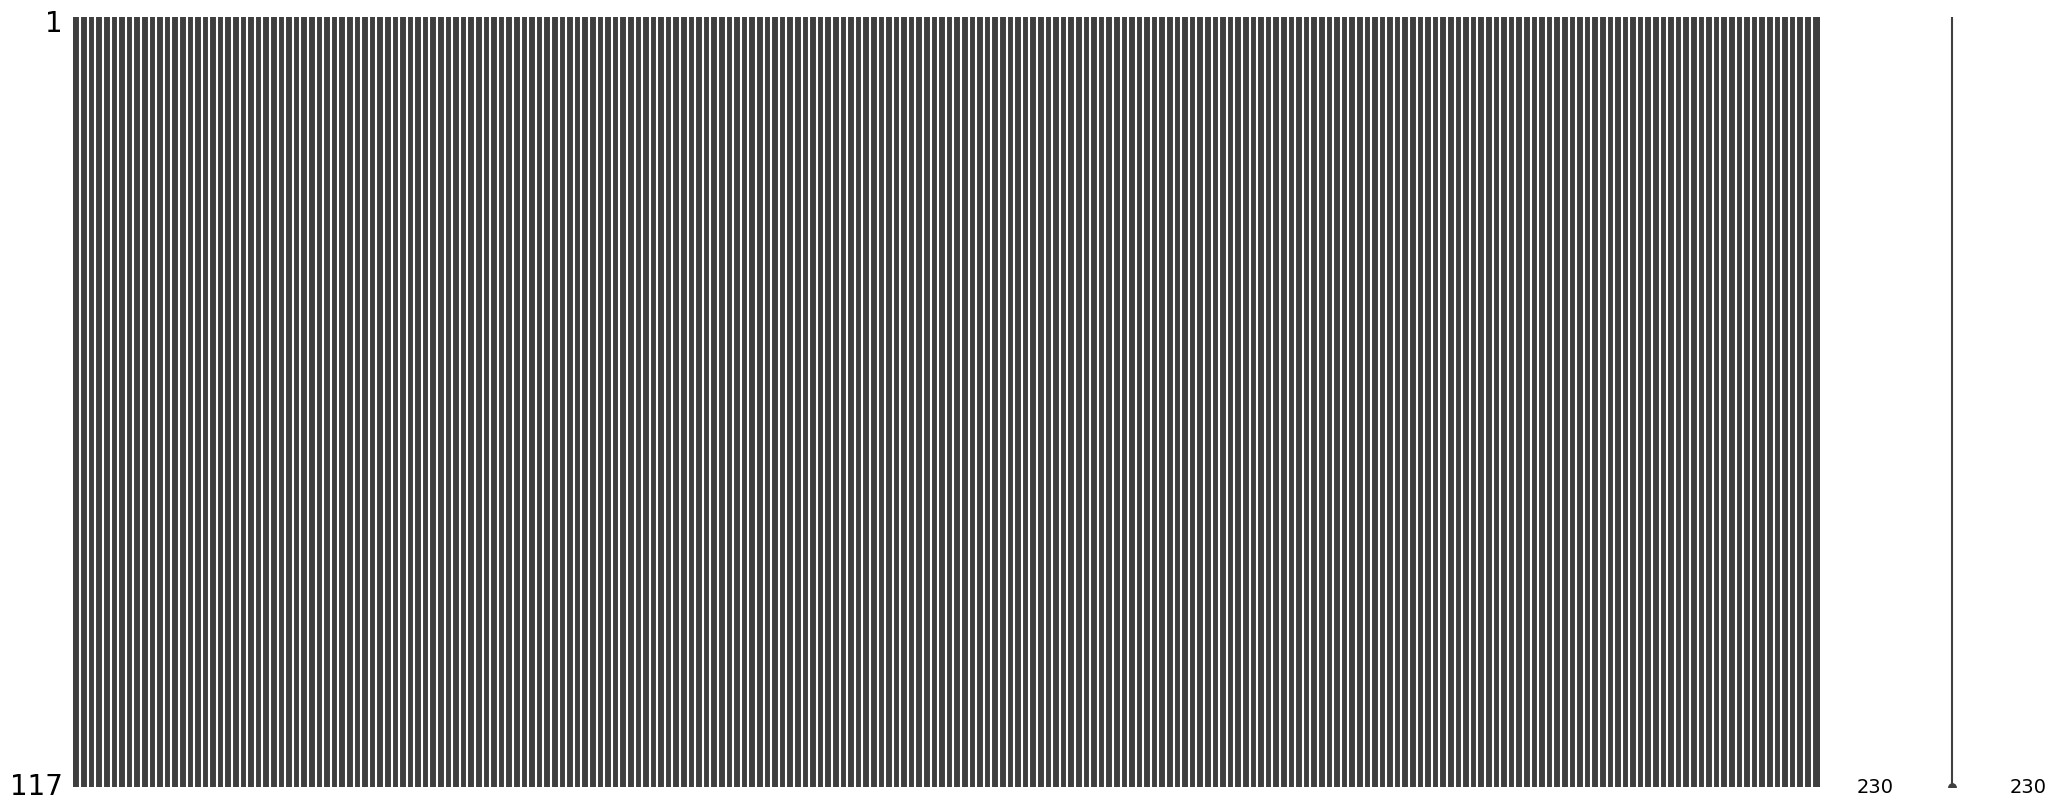

In [24]:
#use pandas concat to merge all our dataframes into the total_df
total_df = pd.concat([saanen, gdp, xrate, ppi, unemployment, weather_chd, weather_gsg, weather_zwe], axis=1, verify_integrity=False, copy=False).drop_duplicates()
#delete columns that are present in multiple dataframes. With this we make sure not to have one column multiple times in our total_df
total_df = total_df.loc[:,~total_df.columns.duplicated()].copy()
#we drop the column named "Unnamed: 0"
total_df.drop(columns="Unnamed: 0", inplace=True)
#check whether we still have na_values in our total_df
ph.show_na(total_df)

In [8]:
#save our total_df in our cleaned data file
total_df.to_csv("../data/cleaned data/total_df.csv")

In [82]:
ols1.fit(X, y)
# Add the predictions to our `crops` dataframe

prediction["pred"] = ols1.predict(X)

# Get value of constant and coefficient
print(f"constant: {ols1.intercept_:.2f}, coefficient: {ols1.coef_[0]:.7f}.")


constant: -174.17, coefficient: 0.0213468.


/var/folders/pj/5_51d77x0lbdcvsbw8bfblkc0000gn/T/ipykernel_34729/2744612607.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction["pred"] = ols1.predict(X)


In [83]:
mse = np.mean((prediction - total_df["Belgium"]) ** 2)
mse # Display the MSE
X

/usr/local/Caskroom/miniconda/base/envs/dsf/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


,Herkunftsland - Total
87,930.0
75,4152.0
39,5723.0
46,6541.0
63,6572.0
...,...
103,50720.0
61,50799.0
73,52540.0
109,52757.0


In [86]:
ols2 = LinearRegression()

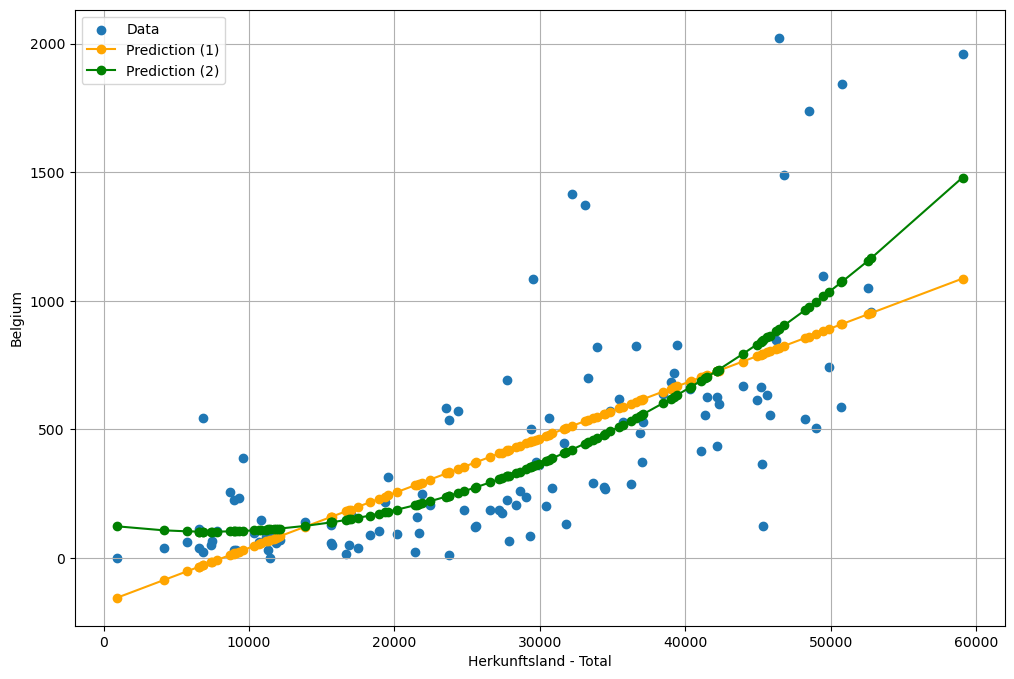

In [89]:
fig, ax = plt.subplots(figsize=(12, 8))
# Add scatterplot
ax.scatter(prediction["Herkunftsland - Total"], prediction["Belgium"], label="Data")
ax.plot(prediction["Herkunftsland - Total"], prediction["pred"], "-o", label="Prediction (1)", color="orange")
ax.plot(prediction["Herkunftsland - Total"], prediction["pred1"], "-o", label="Prediction (2)", color="green")
# Label axes
ax.set_xlabel("Herkunftsland - Total")
ax.set_ylabel("Belgium")
# Add a grid
ax.grid(True)
# Add a legend
ax.legend()